<!--  -->

# Train FashionMNIST using Keras

This notebook focuses on computer vision task using keras. The dataset is [FashionMINST](https://github.com/zalandoresearch/fashion-mnist), which consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The classes are as follows:

 - 0 is T-shirt/top
 - 1 is Trouser
 - 2 is Pullover
 - 3 is Dress
 - 4 is Coat
 - 5 is Sandal
 - 6 is Shirt
 - 7 is Sneaker
 - 8 is Bag
 - 9 is Ankle boot

<img src='https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png'/>FashionMNIST

### Import Necessary Library

In [5]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.models import Sequential

from keras.datasets import fashion_mnist

from sklearn.model_selection import train_test_split

%matplotlib inline

Set up hyperparameter

In [2]:
# class CONFIG:
learning_rate = 5e-4
epochs = 25
batch_size = 320
n_hidden = 512
display_step = 100
num_classes =10
num_features = 28*28
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Load the dataset.

The dataset is loaded from [keras.dataset](https://keras.io/api/datasets/fashion_mnist/)

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print('Fashion MNIST train shape:', train_images.shape, 'type:', train_images.dtype)


# Reshape images, change type and normalise
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255.0
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32') / 255.0
print('Fashion MNIST reshaped\nTrain', train_images.shape, 'type:', train_images.dtype, '\nTest:', test_images.shape, 'type:', test_images.dtype)


#split the test subset to validation and test
val_set_X, test_X, val_set_y, test_y = train_test_split(test_images, test_labels, test_size=0.5)


# Encode the labels
train_labels = keras.utils.to_categorical(train_labels, num_classes) 
val_set_y = keras.utils.to_categorical(val_set_y, num_classes)
test_y = keras.utils.to_categorical(test_y, num_classes)

val_data = (val_set_X, val_set_y)



print(f'\ntrain label shape: {train_labels.shape}\
        \ntest label shape: {test_labels.shape} \
        \nval set shape: {val_set_y.shape} \
        \ntest set shape: {test_y.shape}')

test_labels = keras.utils.to_categorical(test_labels, num_classes)




class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Fashion MNIST train shape: (60000, 28, 28) type: uint8
Fashion MNIST reshaped
Train (60000, 28, 28, 1) type: float32 
Test: (10000, 28, 28, 1) type: float32

train label shape: (60000, 10)        
test label shape: (10000,)         
val set shape: (5000, 10)         
test set shape: (5000, 10)


### Visualize random sample.

It's always good to see things. Seeing is believing 😁😁

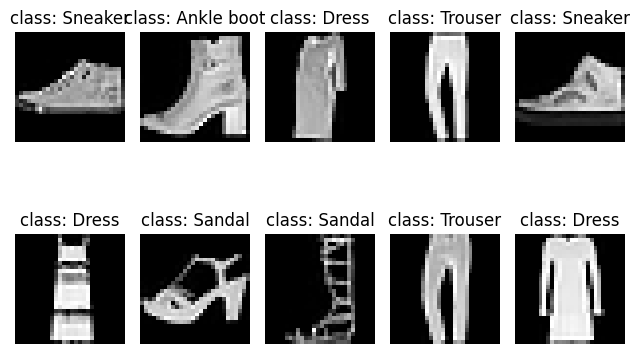

In [4]:
def display_random_image(num):
    '''
    Display n random images
    num: int - any integer from 0 - 59999
    '''
    # try:
    if num > 10:
        print('Max display is 10 images')
    else:

        pool = np.random.randint(0, 60000, num)
        fig, ax = plt.subplots(2, 5)
        ax = ax.flatten()

        for i, idx in enumerate(pool):
            label_idx = np.argmax(train_labels[idx])

            img = train_images[idx]#.reshape((28, 28))
            ax[i].set_title(f'class: {class_names[label_idx]}')
            ax[i].imshow(img, cmap='gray')
            ax[i].axis('off')

        plt.tight_layout()
        plt.show()

display_random_image(10)

### Data Augmentation

In [42]:
import tensorflow as tf

# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,  # Random rotations
    width_shift_range=0.2,  # Horizontal shifts
    height_shift_range=0.2,  # Vertical shifts
    horizontal_flip=True  # Random horizontal flips
)

In [7]:
model = Sequential([Conv2D(filters=64, input_shape=train_images.shape[1:], activation='relu', kernel_size=3, padding='same'),
                    MaxPooling2D(strides=2, padding='same'),

                    # build second convolutional layer
                    Conv2D(filters=64, kernel_size=3, padding='same',),
                    # Ensure some regularisation with this guy.
                    BatchNormalization(),
                    Activation('relu'),
                    MaxPooling2D(strides=2),


                    Flatten(),

                    Dense(512, activation='relu'),
                    Dropout(0.2),

                    Dense(num_classes, activation='softmax')])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)         

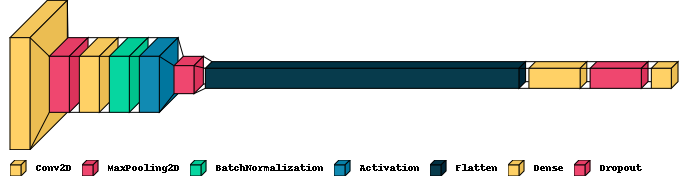

In [8]:
try:
    import visualkeras
except:
    !pip install -q visualkeras
    import visualkeras

structure = visualkeras.layered_view(model, legend=True)
structure

In [12]:
def train_model(augment=True):
    model.compile(optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, weight_decay=0.0, amsgrad=False),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    if augment:
        return model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=val_data)
    else:
        return model.fit(train_images, train_labels, batch_size=batch_size,
                        epochs=epochs,
                        validation_data=val_data)

history = train_model(augment=False)

Epoch 1/25
188/188 [==============================] - 73s 377ms/step - loss: 0.4850 - accuracy: 0.8281 - val_loss: 1.4890 - val_accuracy: 0.8604
Epoch 2/25
188/188 [==============================] - 66s 349ms/step - loss: 0.2906 - accuracy: 0.8945 - val_loss: 0.7112 - val_accuracy: 0.8904
Epoch 3/25
188/188 [==============================] - 69s 366ms/step - loss: 0.2490 - accuracy: 0.9092 - val_loss: 0.3121 - val_accuracy: 0.8968
Epoch 4/25
188/188 [==============================] - 70s 373ms/step - loss: 0.2223 - accuracy: 0.9192 - val_loss: 0.2714 - val_accuracy: 0.8986
Epoch 5/25
188/188 [==============================] - 66s 353ms/step - loss: 0.2031 - accuracy: 0.9247 - val_loss: 0.2461 - val_accuracy: 0.9068
Epoch 6/25
188/188 [==============================] - 68s 364ms/step - loss: 0.1820 - accuracy: 0.9333 - val_loss: 0.2311 - val_accuracy: 0.9174
Epoch 7/25
188/188 [==============================] - 68s 363ms/step - loss: 0.1679 - accuracy: 0.9376 - val_loss: 0.2309 - val_ac

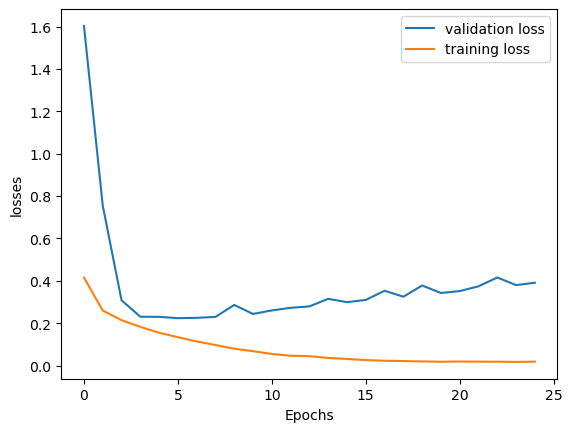

In [58]:
plt.plot(range(epochs), history.history['val_loss'], label='validation loss')
plt.plot(range(epochs), history.history['loss'], label='training loss')
plt.xlabel('Epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

In [59]:
sample_test = test_X[:3000].reshape(-1, 28, 28, 1)
performance = model.evaluate(sample_test, test_y[:3000])

print(f'\ntest loss: {performance[0]:.2f}\naccuracy: {performance[1]:.2f}')

94/94 [==============================] - 1s 10ms/step - loss: 0.4015 - accuracy: 0.9270

test loss: 0.40
accuracy: 0.93


### Save the model for testing on unseen images

With unseen images, we'll see how the model accurately labels them.

In [61]:
model.save('fashionMNIST.keras')
loaded_model = tf.keras.models.load_model('fashionMNIST.keras')

### Visualize some samples

1/1 [==============================] - 0s 31ms/step


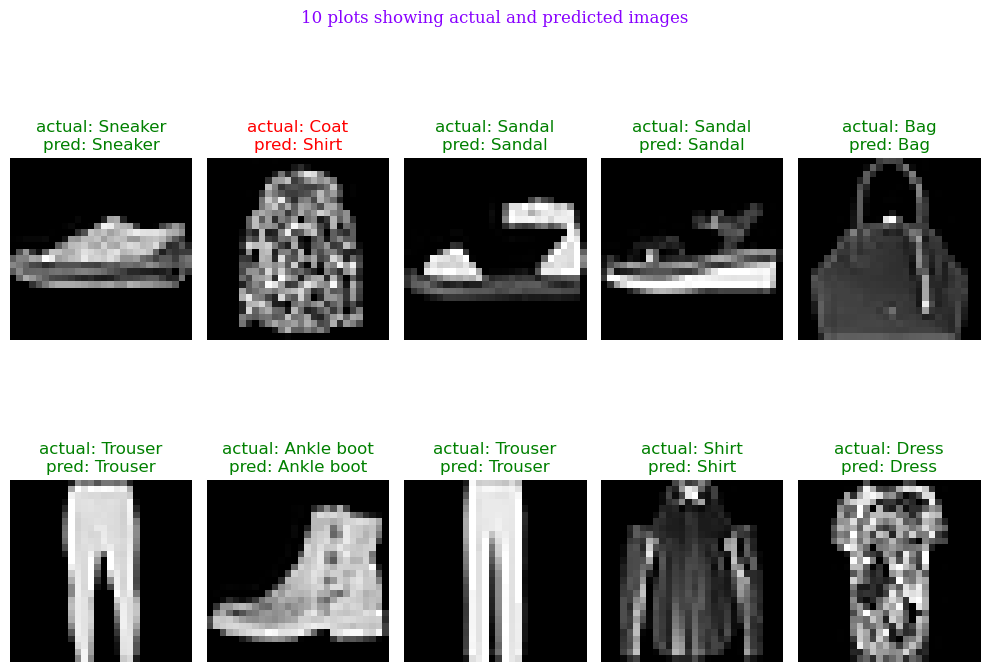

In [65]:
def visualize_classification(num=10):
    images_pool, labels_pool = test_images[3000:], test_labels[3000:]

    # sample num of images and get the corresponding labels
    sample = np.random.randint(0, 2000, num)
    random_images = images_pool[sample]
    label = labels_pool[sample]

    # predict the sampled images using the model
    pred = np.argmax(loaded_model.predict(random_images.reshape(-1, 28, 28, 1)), axis=1)

    # visualize num of predicted and acutal images

    font = {'family': 'serif',
        'color':  '#8800ff',
        'weight': 'bold',
        'size': 30}

    fig, axes = plt.subplots(2, num//2, figsize=(10, 8))

    fig.suptitle(f'{num} plots showing actual and predicted images', fontdict=font)

    for i, ax in enumerate(axes.flat):

        ax.imshow(random_images[i].reshape(28, 28), cmap='gray')

        if class_names[label[i].argmax()] == class_names[pred[i]]:
            ax.set_title(f'actual: {class_names[label[i].argmax()]}\npred: {class_names[pred[i]]}', fontdict={'color': 'g'})
        else:
            ax.set_title(f'actual: {class_names[label[i].argmax()]}\npred: {class_names[pred[i]]}', fontdict={'color': 'r'})
        ax.axis('off')

    plt.tight_layout()
    plt.show()


visualize_classification(10)


# Thank you for viewing